In [1]:
import gym
import seagul.envs

env = gym.make('su_acro_drake-v0')


import torch
import torch.nn as nn

from seagul.nn import CategoricalMLP, MLP, DummyNet, fit_model, LinearNet

# TODO maybe import algos into rl __init__
from seagul.rl.algos import ppo_switch
from seagul.rl.algos import ppo

from tqdm import trange
from numpy import pi
import numpy as np

import matplotlib.pyplot as plt

#torch.set_default_dtype(torch.double)

policy = MLP(input_size=4, output_size=1, layer_size=24, num_layers=2, activation=nn.ReLU)
value_fn = MLP(input_size=4, output_size=1, layer_size=24, num_layers=2, activation=nn.ReLU)

#policy = LinearNet(17,6)
#value_fn = LinearNet(17,1)
gate_fn = CategoricalMLP(input_size=4, output_size=1, layer_size=32, num_layers=2, activation=nn.Tanh)

/home/sgillen/work/seagul/seagul/envs/__init__.py:77: UserWarning: Warning, registering environments for rllib failed!
  warnings.warn("Warning, registering environments for rllib failed!")
/home/sgillen/miniconda3/envs/drake/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/sgillen/miniconda3/envs/drake/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/sgillen/miniconda3/envs/drake/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type i

In [92]:
#%%timeit

# Generate data for the supervised learning task
from numpy import arctan2, pi
env = gym.make('su_acro_drake-v0')
obs = env.reset()
num_points = int(2e4)

X = torch.zeros(num_points, 4)  
Y = torch.zeros(num_points,1)
#y_list.append

for i in trange(num_points):
        
        state  = env.observation_space.sample()
        #state = np.array([arctan2(obs[0],obs[1]), arctan2(obs[2], obs[3]), obs[4], obs[5]])
        X[i] = torch.as_tensor(state)
       
        if((140 * pi/180 < state[0] < 220 * pi/180) and ((-40*pi/180 < state[1] < 40 * pi/180))):#) and -5 < state[2] < 5 and -10 < state[3] < 10):
            Y[i] = 7
        else:
            Y[i] = 0

            
            
print(sum(Y))
# fit our gating network to the data we generated above

gate_fn.state_means = X.mean(0)
gate_fn.state_var = X.var(0)

100%|██████████| 20000/20000 [00:00<00:00, 21370.30it/s]


tensor([6902.])


In [48]:
import pickle
X = pickle.load(open('./warm/X_zv_128', 'rb'))
Y = pickle.load(open('./warm/Y_zv_128', 'rb'))

X = np.array(X, dtype=np.float32)
Y = np.array(Y, dtype=np.float32).reshape(-1,1)

normal_const = (np.sqrt((len(Y)/(sum(Y)*2)),dtype=np.float32))
#normal_const = 4
Y *= normal_const

print(sum(Y))
print(len(Y))

[1514.513]
16384


100%|██████████| 50/50 [00:10<00:00,  4.65it/s]


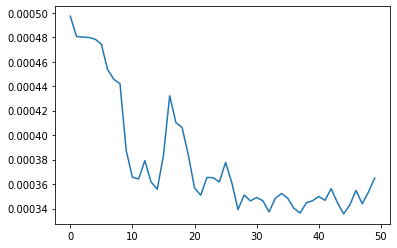

In [55]:
gate_fn = CategoricalMLP(input_size=4, output_size=1, layer_size=64, num_layers=3, activation=nn.Tanh)

hist = fit_model(gate_fn,X,Y,50, batch_size=1024)
plt.plot(hist)

In [56]:
# evauluate how well our classifier is doing now

#env = gym.make('su_acrobot-v0')
num_points = int(2e4)

pred_Y = torch.zeros(num_points,1)
pred_X = np.zeros((num_points,1))
up_wrong = 0; up_right = 0; down_wrong = 0; down_right = 0;
y_list = []

for i in trange(num_points):
        
        state = env.observation_space.sample()
        #state = np.array([arctan2(obs[0],obs[1]), arctan2(obs[2], obs[3]), obs[4], obs[5]])

        y = gate_fn(torch.as_tensor(state,dtype=torch.float32))
        y_list.append(y)
        
        if((140 * pi/180 < state[0] < 220 * pi/180) and ((-40*pi/180 < state[1] < 40 * pi/180)) and (-5 < state[2] < 5) and (-10 < state[3] < 10)):
            if y < .5:
                #print("wrong!" , c)
                up_wrong +=1
            else:
                up_right +=1
        else:
            if y > .5:
                #print("wrong again!" , c)
                down_wrong +=1
            else:
                down_right +=1
       
print("balancing controller misclassified: " , up_wrong)
print("balancing controller corectly classified: " , up_right)
print("balancing controller accuracy: " , up_right/(up_right+up_wrong))

     
print("swingup controller misclassified: " , down_wrong)
print("swingup controller corectly classified: " , down_right)
print("swingup controller accuracy: " , down_right/(down_right+down_wrong))

100%|██████████| 20000/20000 [00:04<00:00, 4313.67it/s]

balancing controller misclassified:  109
balancing controller corectly classified:  63
balancing controller accuracy:  0.36627906976744184
swingup controller misclassified:  5360
swingup controller corectly classified:  14468
swingup controller accuracy:  0.7296752067782933


In [77]:
t_policy, t_val, rewards, var_dict = ppo('su_cartpole-v0', 100, policy, value_fn, action_var = .4, p_epochs= 5, v_epochs=15)
#t_policy, t_val, t_gate, rewards, var_dict = ppo_switch(
#    "su_cartpole_push-v0", 500, policy, value_fn, gate_fn, epoch_batch_size=50, reward_stop=1400
#)

plt.plot(rewards)

TypeError: ppo() got an unexpected keyword argument 'action_var'

In [4]:
torch.save(gate_fn, ".gate_fn_ppo2")

In [ ]:
save_path = "./data/push_baselines/push_baseline1"
#model, env = load_model(save_path) # This is loading the trained model for analysis
t_data = pd.read_csv(save_path + '/progress.csv' ) # This is data about the training

In [ ]:
plt.plot(var_dict['action_list'])

In [ ]:
plt.plot(var_dict['path_list'])

In [ ]:
plt.plot(np.array(var_dict['state_tensor'])[:,2])
np.array(var_dict['state_tensor'])

In [ ]:
var_dict['action_tensor']

In [63]:
torch.save(gate_fn, "gate_fn_ppo2_nz128")

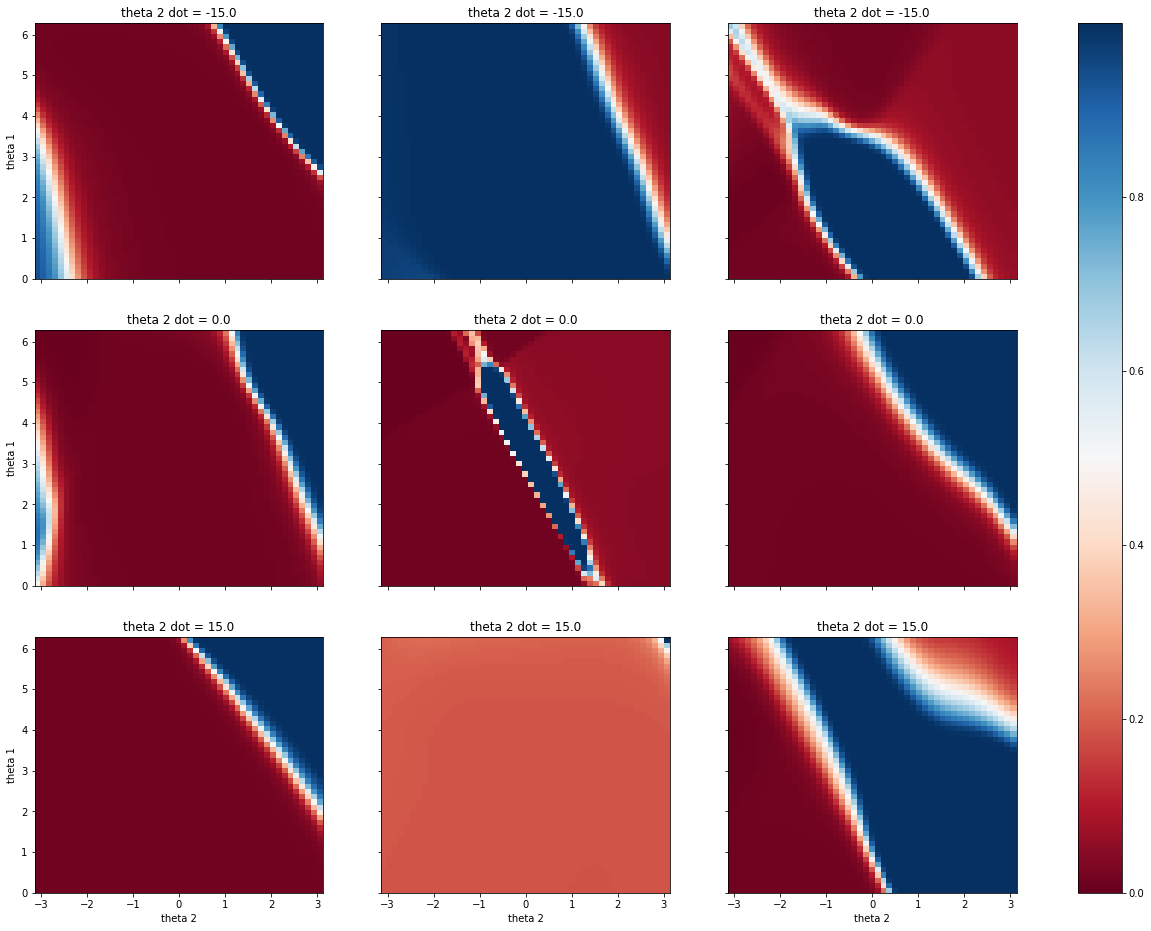

In [57]:
import matplotlib.pyplot as plt
import numpy as np
from numpy import sin,cos

n_thdot = 3
n_th = 50
fig, ax = plt.subplots(n_thdot,n_thdot, figsize=(22,16))

th1_vals = np.linspace(0,2*pi,n_th)
th2_vals = np.linspace(-pi,pi,n_th)

th1dot_vals = np.linspace(-10,10,n_thdot)
th2dot_vals = np.linspace(-15,15,n_thdot)

for th1i, th1dot in enumerate(th1dot_vals):
    for th2i, th2dot in enumerate(th2dot_vals):
       
        means = np.zeros((n_th,n_th))

        for i,th1 in enumerate(th1_vals):
            for j,th2 in enumerate(th2_vals):
                #obs = torch.tensor([cos(th1), sin(th1), cos(th2), sin(th2), th1dot,th2dot])
                obs = torch.tensor([th1, th2, th1dot, th2dot])
                means[i,j] = gate_fn(obs)



        # generate 2 2d grids for the x & y bounds
        y, x = np.meshgrid(th1_vals, th2_vals)
        z = means

        # x and y are bounds, so z should be the value *inside* those bounds.
        # Therefore, remove the last value from the z array.
        z = z[:-1, :-1]
        z_min, z_max = 0, np.abs(z).max()


        c = ax[th1i, th2i].pcolormesh(x, y, z, cmap='RdBu', vmin=z_min, vmax=z_max)
        #ax.set_title('pcolormesh')
        # set the limits of the plot to the limits of the data
        ax[th1i, th2i].axis([x.min(), x.max(), y.min(), y.max()])

        #plt.show()
        
for i,a in enumerate(ax):
    for j,b in enumerate(a):
        b.set(ylabel = "theta 1", xlabel="theta 2", title="theta 2 dot = " + str(th2dot_vals[i]))
        b.label_outer()
        
fig.colorbar(c, ax=ax)